# Finding best hyperparameters for emu_v1

Deciding which hyperparameters are the best for emu_v1

In [1]:
# %load first_cell.py
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import black
import jupyter_black
        
jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import numpy as np
import os
import sys
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.26, Om0=0.314, Ob0=0.049)

from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"


def print_shape(*args):
    nelem = len(args)
    for ii in range(nelem - 1):
        print(args[ii].shape, end=" ")
    print(args[nelem - 1].shape)


def ls_level(folder, nlevels):
    for ii in range(nlevels):
        folder = os.path.dirname(folder)
    folder += "/"
    return folder


path_program = ls_level(os.getcwd(), 1)
print(path_program)
sys.path.append(path_program)

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

/home/jchaves/Proyectos/projects/lya/lya_pk/


In [2]:
from lya_pk.archive import GadgetArchive3D
from lya_pk.emulator_p3d import P3DEmulator
import random, torch

## Load training data

In [3]:
%%time
folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program, folder_data=folder_lya_data
)
print(len(Archive3D.training_data))

1650
CPU times: user 11.9 s, sys: 1.57 s, total: 13.5 s
Wall time: 14.4 s


In [4]:
testing_data = Archive3D.get_testing_data(
    "mpg_central", force_recompute_plin=False
)

## Training

### Variance between training sets

A lot! In some cases no convergence

In [4]:
olr = 1e-3
obs = 50
oss = 90
og = 0.1
owd = 0.01
ohid = 2

In [6]:
niter = 1
res = []

for ii in range(niter):
    torch.manual_seed(ii)
    np.random.seed(ii)
    random.seed(ii)

    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=owd,
        nhidden=ohid,
        adamw=True,
    )
    arr = np.array(p3d_emu.loss_arr)
    res.append(np.mean(arr, axis=1))

1  out of  1
Emualtor trained in 15.097241640090942 seconds


18.90385526599306


<IPython.core.display.Javascript object>


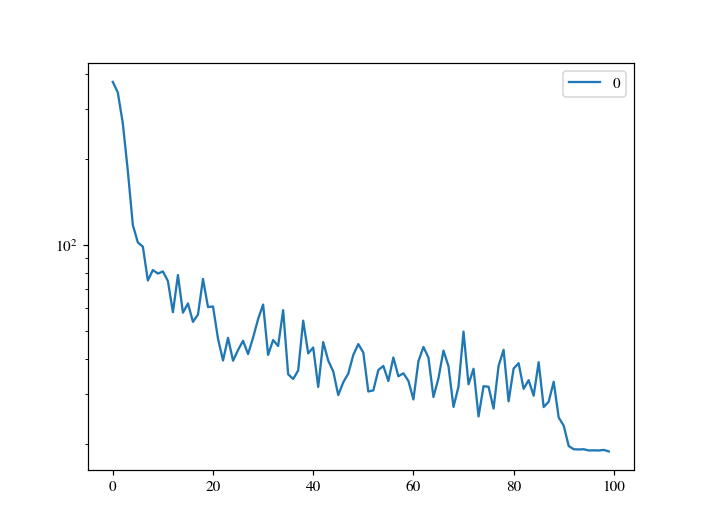

In [7]:
bot = np.min(res)
print(bot)
burn_in = 0
for ii in range(niter):
    plt.plot((res[ii])[burn_in:], label=str(ii))
# plt.ylim([-0.01, 1])
plt.legend()

### Xavier

In [10]:
niter = 2
res = []
lxab = [False, True]

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=0.1,
        weight_decay=0.01,
        nhidden=2,
        init_xavier=lxab[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res.append(np.mean(arr, axis=1))

1  out of  2
Emualtor trained in 33.35726594924927 seconds
2  out of  2
Emualtor trained in 33.43050265312195 seconds


188603.66761363635


<IPython.core.display.Javascript object>


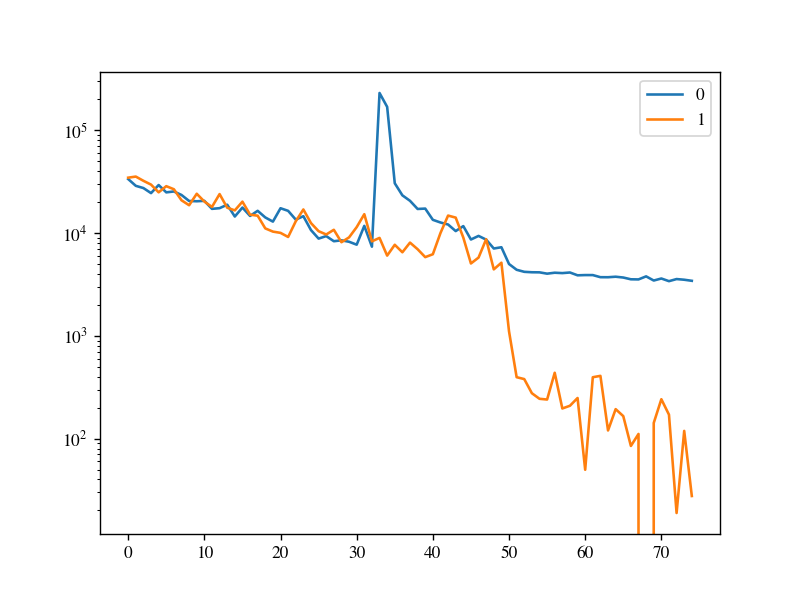

In [15]:
bot = np.min(res)
print(bot)
burn_in = 25
for ii in range(2):
    plt.plot((res[ii] - bot)[burn_in:], label=str(ii))
# plt.ylim([-0.01, 1])
plt.legend()

### Learning rate

best = 0.01

In [12]:
olr = 5e-3
obs = 200
oss = 90
og = 0.1
owd = 0.01
ohid = 2

In [9]:
lr_values = np.array([1e-3, 5e-3, 1e-2])
niter = lr_values.shape[0]
res_lr = []

for ii in range(niter):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=owd,
        nhidden=ohid,
        adamw=True,
        lr=lr_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_lr.append(np.mean(arr, axis=1))

1  out of  3


TypeError: 'NoneType' object is not subscriptable

In [ ]:
bot = np.min(res_lr)
print(bot)
for ii in range(len(lr_values)):
    plt.plot(res_lr[ii], label=str(lr_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

p1d

In [10]:
lr_values = np.array([1e-3, 5e-3, 1e-2])
niter = lr_values.shape[0]
res_lr = []

for ii in range(niter):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    print(ii + 1, " out of ", niter)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        rerr_p1d=Archive3D.rel_err_p1d,
        target_space="p3dp1d",
        nepochs=100,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=owd,
        nhidden=ohid,
        adamw=True,
        lr=lr_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_lr.append(np.mean(arr, axis=1))

1  out of  3
Emualtor trained in 69.60677933692932 seconds
2  out of  3
Emualtor trained in 65.81629824638367 seconds
3  out of  3
Emualtor trained in 76.16914558410645 seconds


18.201840294731987


<IPython.core.display.Javascript object>


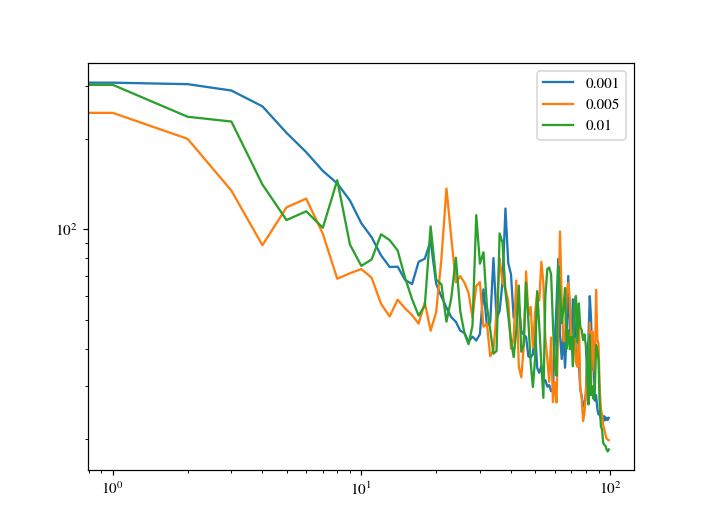

In [11]:
bot = np.min(res_lr)
print(bot)
for ii in range(len(lr_values)):
    plt.plot(res_lr[ii], label=str(lr_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### AMSGrad

In [26]:
niter = 2
amsgrad_values = np.array([False, True])
res_amsgrad = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        nhidden=2,
        lr=olr,
        amsgrad=amsgrad_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_amsgrad.append(np.mean(arr, axis=1))

1  out of  2
Emualtor trained in 36.82040476799011 seconds
2  out of  2
Emualtor trained in 27.00244903564453 seconds


<IPython.core.display.Javascript object>


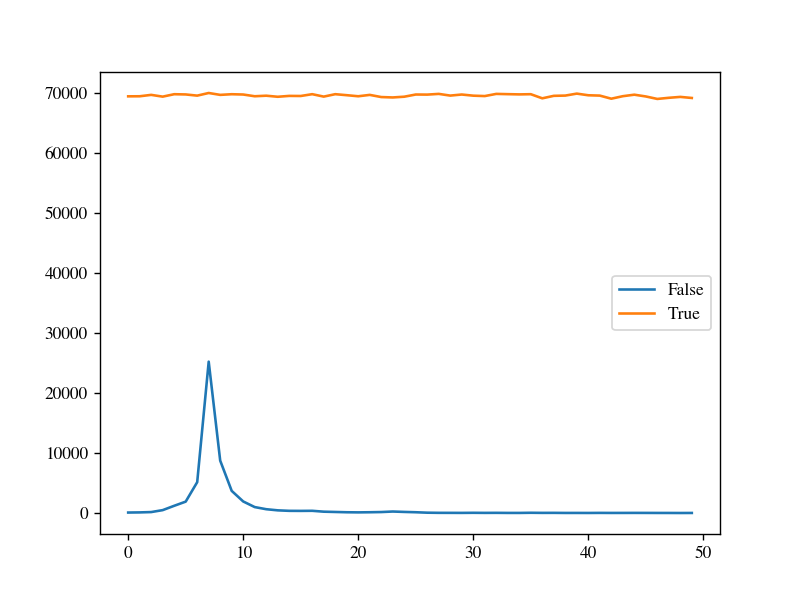

In [29]:
bot = np.min(res_amsgrad)
print(bot)
burn_in = 50
for ii in range(len(res_amsgrad)):
    plt.plot((res_amsgrad[ii] - bot)[burn_in:], label=str(amsgrad_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### Batch_size

best 25

In [22]:
niter = 3
# batch_values = np.array([25, 50, 100])
batch_values = np.array([100, 200, 400])
res_batch = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        nhidden=2,
        lr=olr,
        batch_size=int(batch_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_batch.append(np.mean(arr, axis=1))

1  out of  3
Emualtor trained in 22.572681188583374 seconds
2  out of  3
Emualtor trained in 13.574492692947388 seconds
3  out of  3
Emualtor trained in 11.615330219268799 seconds


1.0469059329562718


<IPython.core.display.Javascript object>


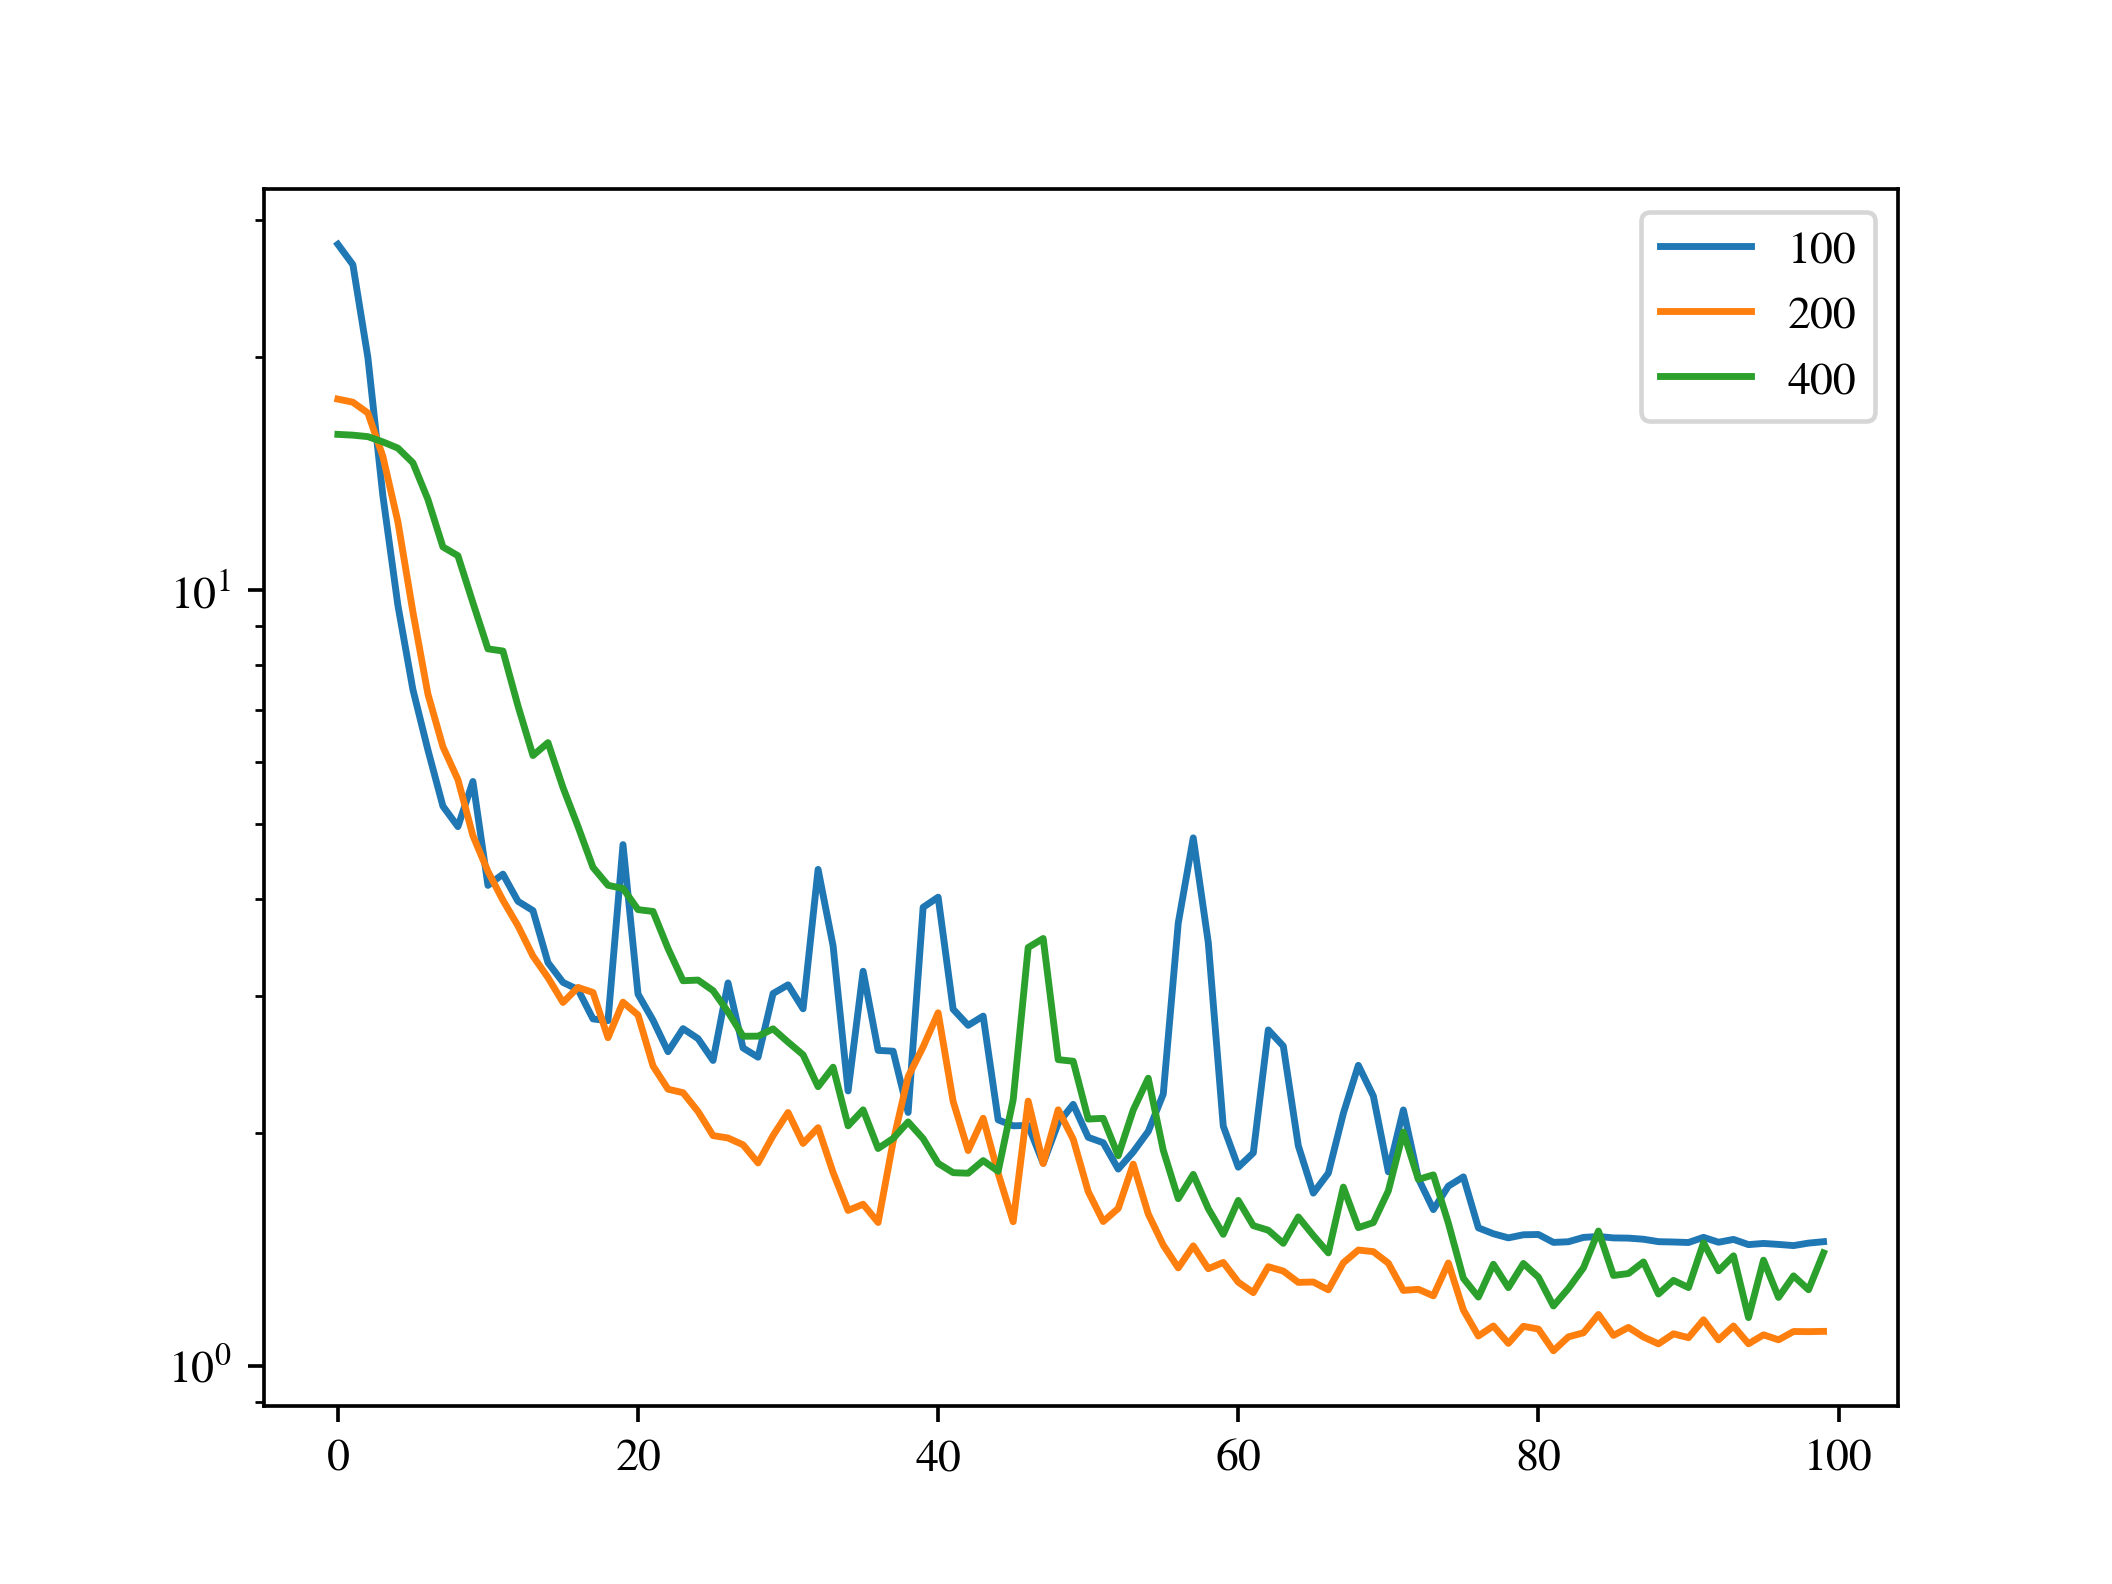

In [23]:
bot = np.min(res_batch)
print(bot)
for ii in range(len(batch_values)):
    plt.plot(res_batch[ii], label=str(batch_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### Decay step

best 50

In [10]:
niter = 4
step_values = np.array([25, 50, 75, 100])
res_step = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        nhidden=2,
        lr=olr,
        batch_size=obs,
        step_size=int(step_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_step.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 24.202397108078003 seconds
2  out of  4
Emualtor trained in 28.46679949760437 seconds
3  out of  4
Emualtor trained in 25.62434458732605 seconds
4  out of  4
Emualtor trained in 16.99669885635376 seconds


2.1687246010520247


<IPython.core.display.Javascript object>


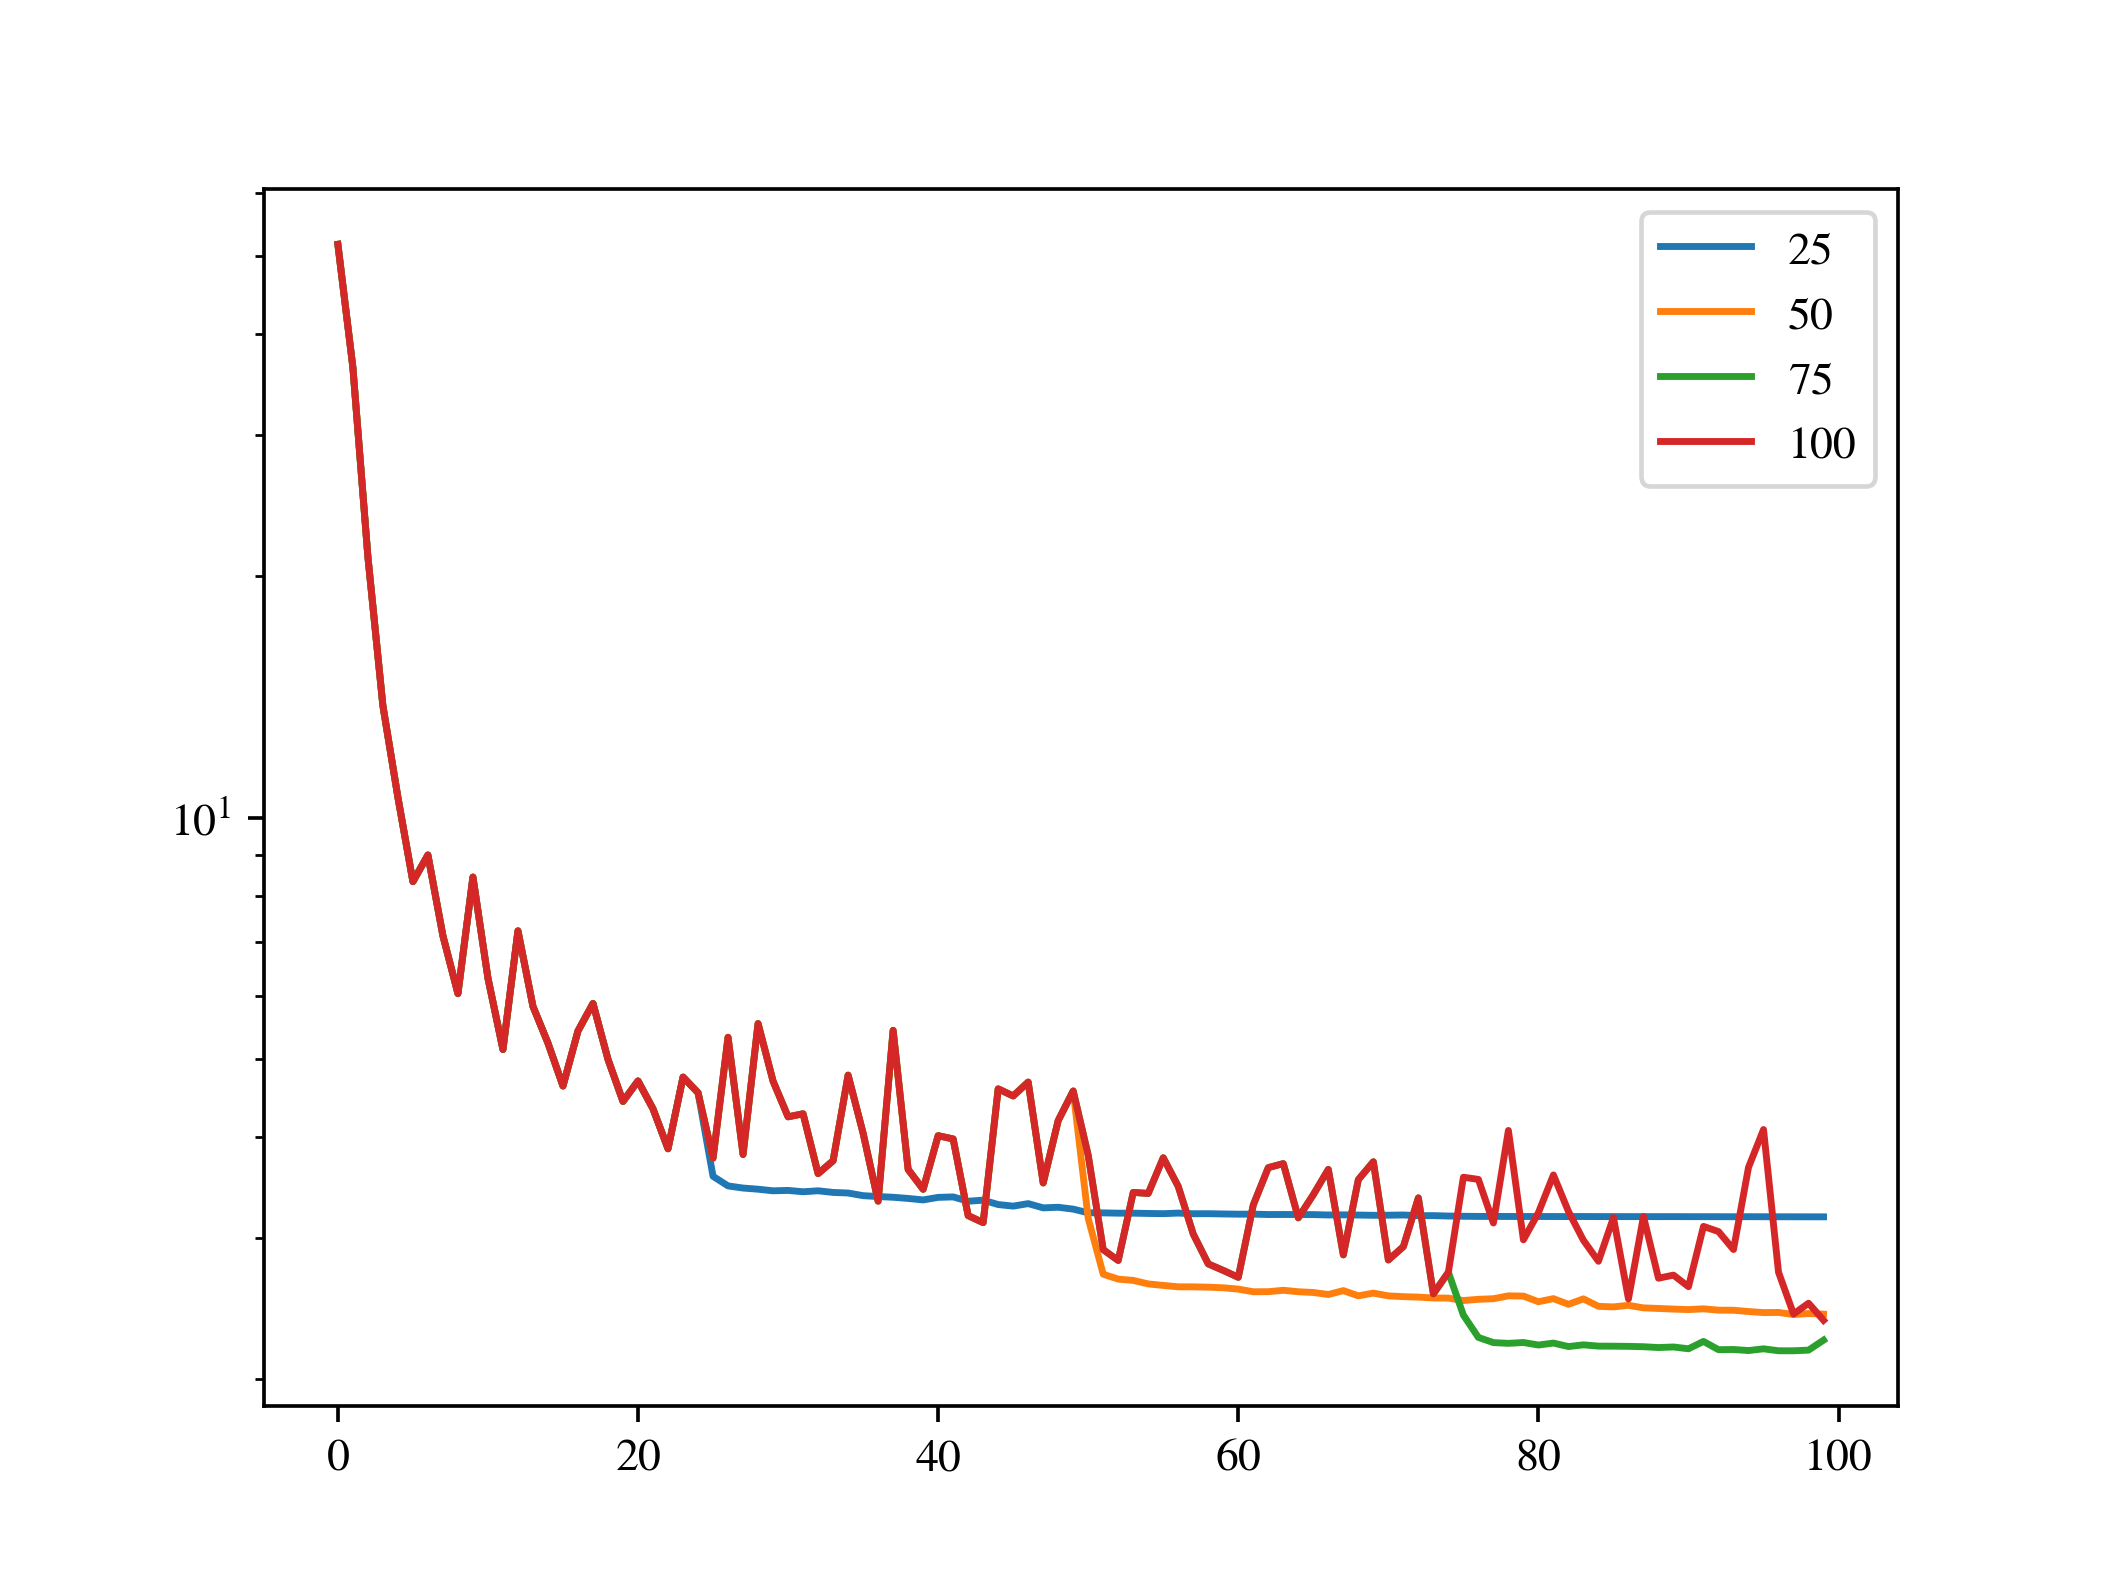

In [19]:
bot = np.min(res_step)
print(bot)
for ii in range(len(step_values)):
    plt.plot(res_step[ii], label=str(step_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### Decay gamma

best 0.1

In [11]:
niter = 4
gamma_values = np.array([1, 0.5, 0.1, 0.05])
res_gamma = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        nhidden=2,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=gamma_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_gamma.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 17.40657091140747 seconds
2  out of  4
Emualtor trained in 27.90642261505127 seconds
3  out of  4
Emualtor trained in 24.70075798034668 seconds
4  out of  4
Emualtor trained in 19.079166173934937 seconds


2.0937833196466618


<IPython.core.display.Javascript object>


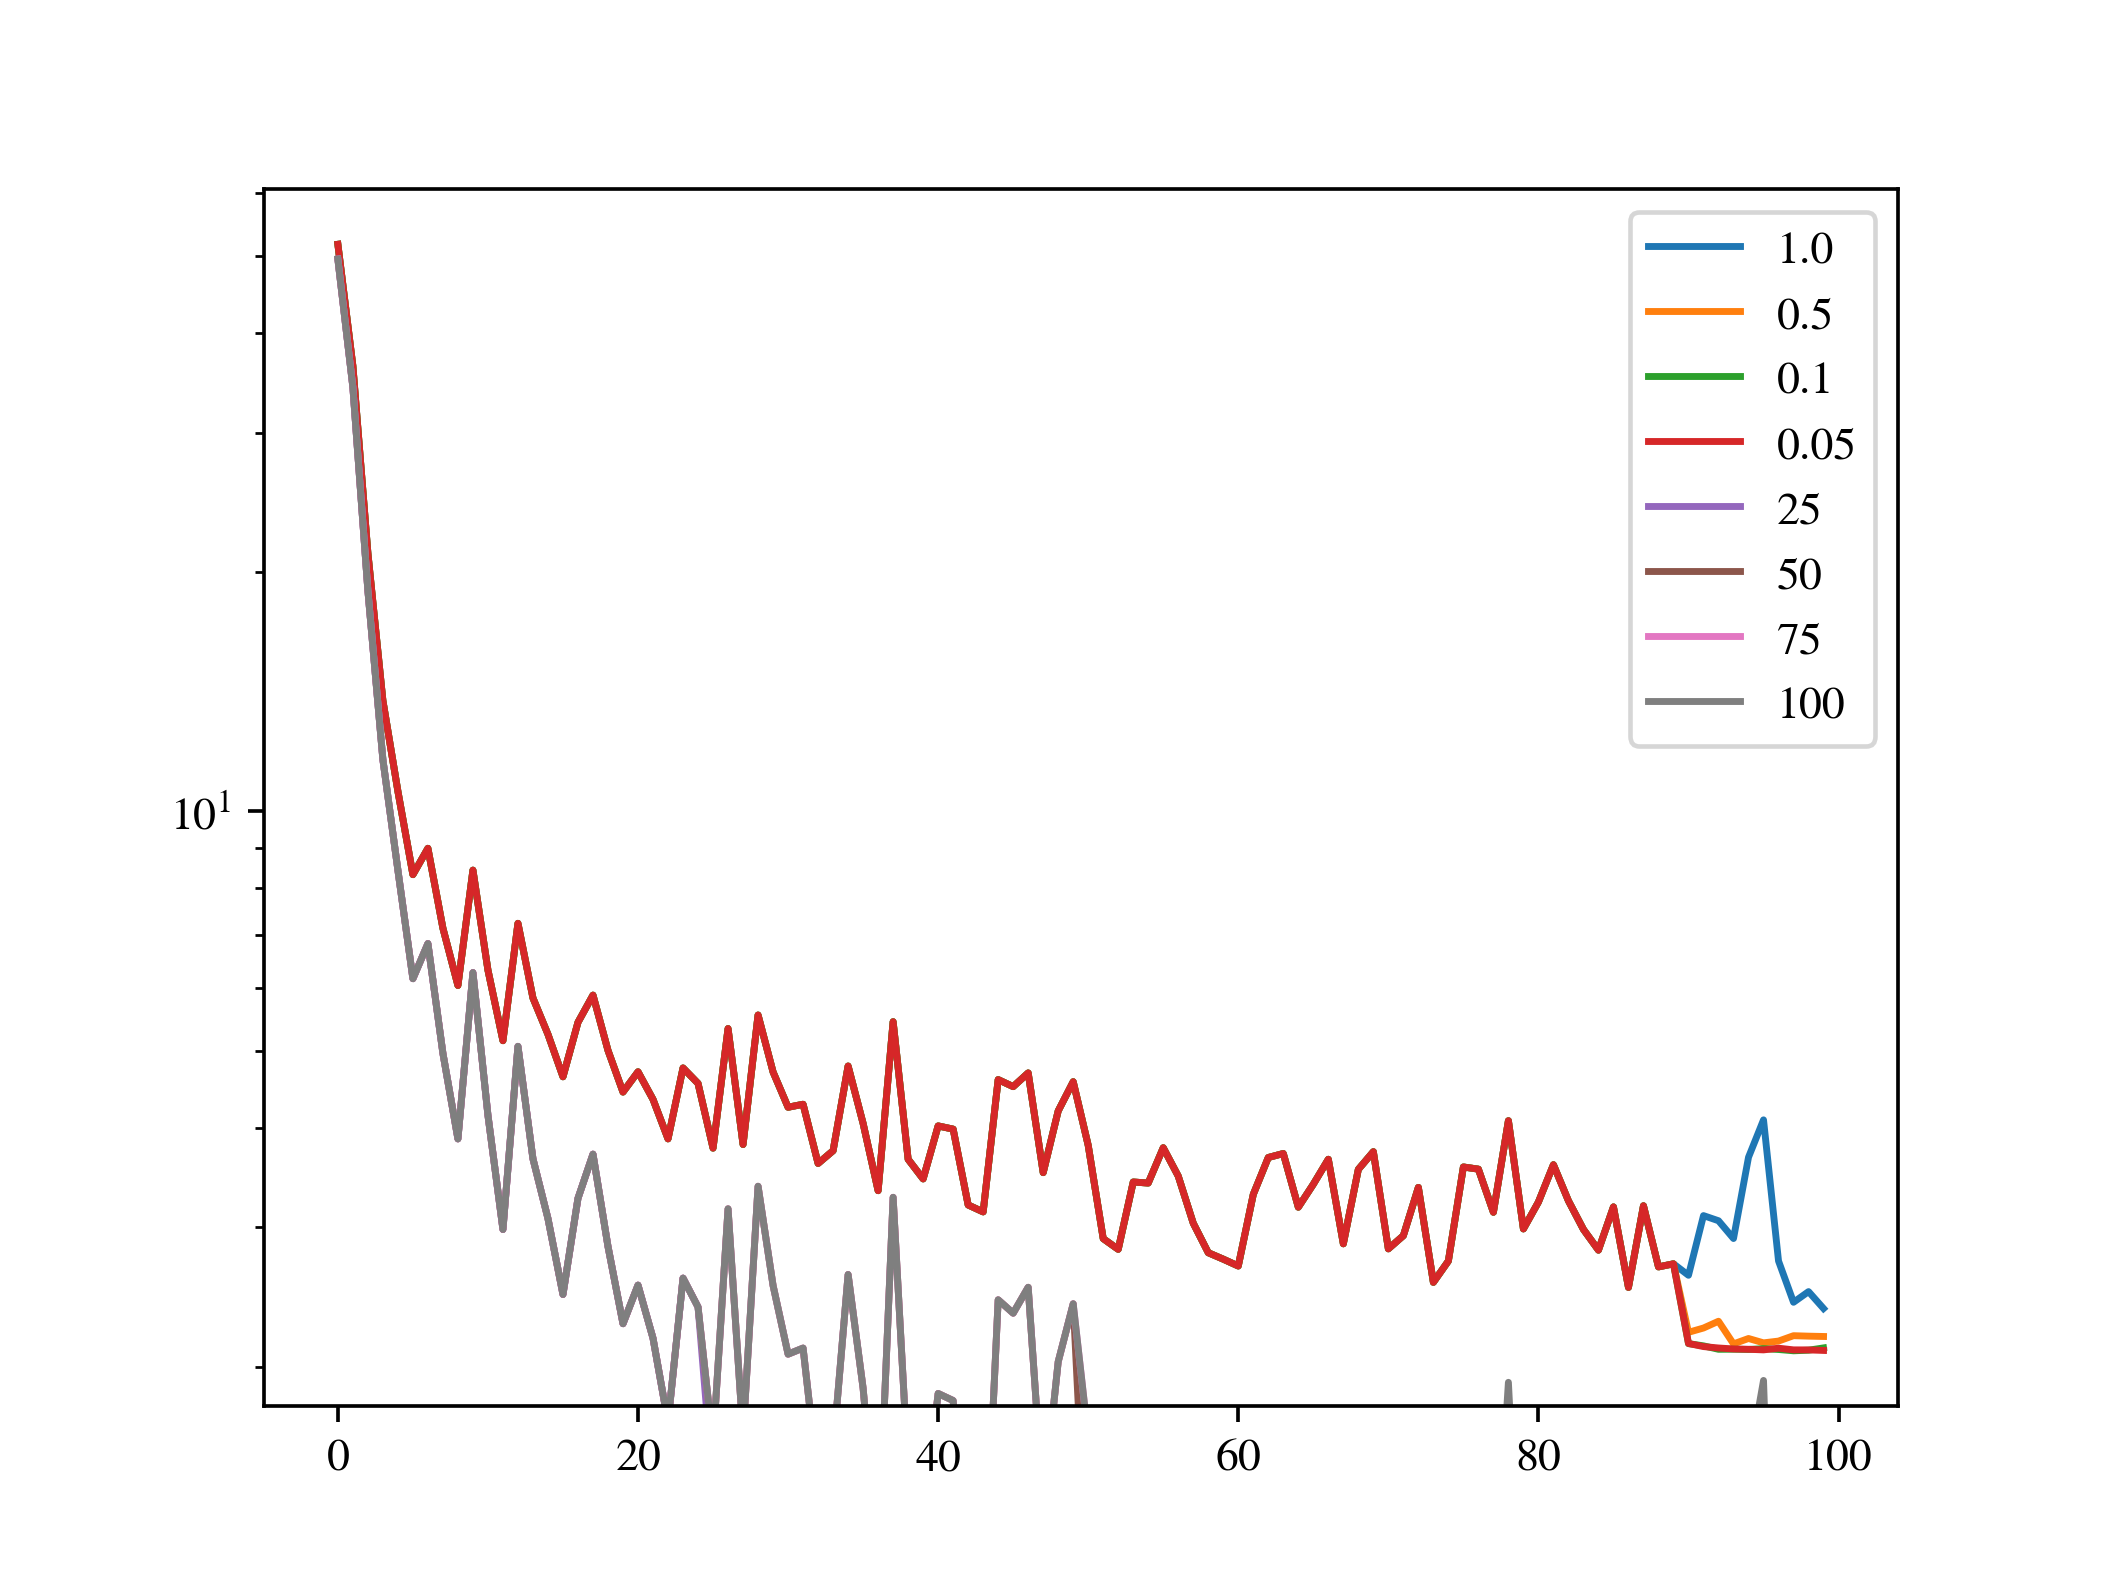

In [17]:
bot = np.min(res_gamma)
print(bot)
for ii in range(len(gamma_values)):
    plt.plot(res_gamma[ii], label=str(gamma_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### Weight decay
0.01

In [12]:
niter = 4
wd_values = np.array([0, 1e-2, 1e-3, 1e-4])
res_wd = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        nhidden=2,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=wd_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_wd.append(np.mean(arr, axis=1))

1  out of  4
Emualtor trained in 27.00061345100403 seconds
2  out of  4
Emualtor trained in 25.02742648124695 seconds
3  out of  4
Emualtor trained in 22.2023983001709 seconds
4  out of  4
Emualtor trained in 23.784157514572144 seconds


2.090459039861506


<IPython.core.display.Javascript object>


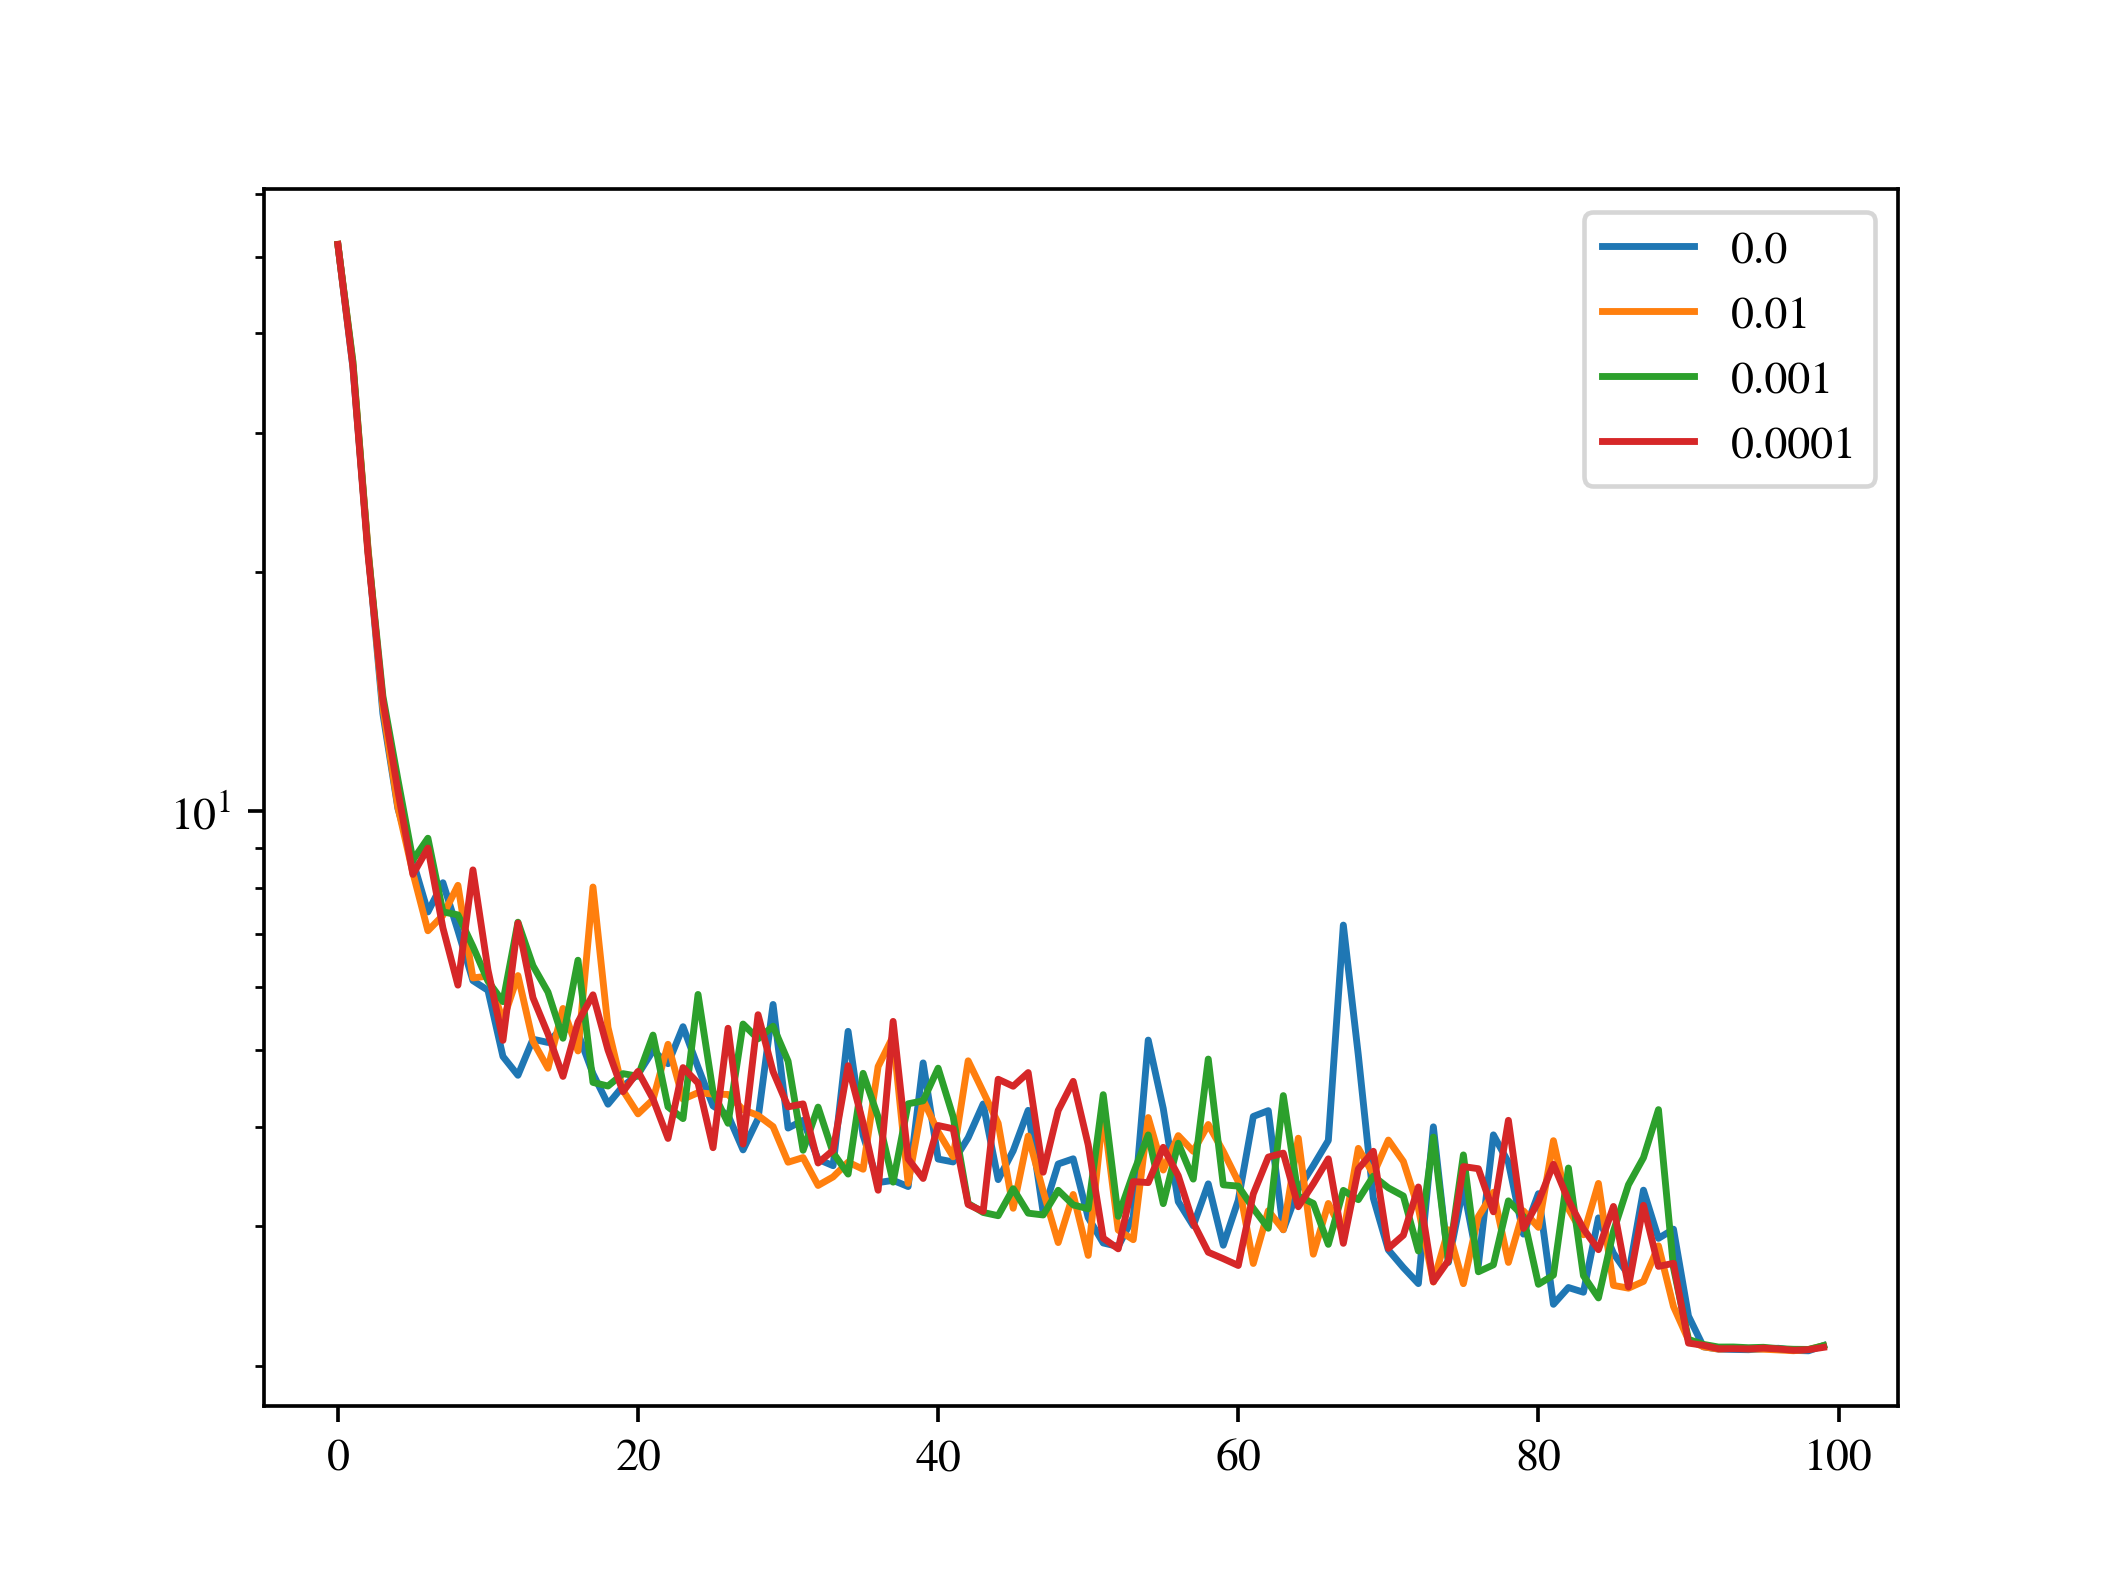

In [15]:
bot = np.min(res_wd)
print(bot)
for ii in range(len(wd_values)):
    plt.plot(res_wd[ii], label=str(wd_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

In [50]:
olr = 5e-3
obs = 200
og = 0.1
owd = 0.01
ohid = 2
oss = 80
nepochs = 150
nwidth1 = nwidth2 = 5

In [51]:
niter = 1
niter = 2
wd_values = np.array([0.1, 1e-2, 1e-3, 1e-4])
res_wd = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        rerr_p1d=Archive3D.rel_err_p1d,
        target_space="p3dp1d",
        nwidth1=nwidth1,
        nwidth2=nwidth2,
        new_arch=True,
        nepochs=nepochs,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=wd_values[ii],
        nhidden=1,
    )
    arr = np.array(p3d_emu.loss_arr)
    res_wd.append(np.mean(arr, axis=1))

1  out of  2
Emualtor trained in 76.1654703617096 seconds
2  out of  2
Emualtor trained in 73.78295874595642 seconds


28.19449912177192


<IPython.core.display.Javascript object>


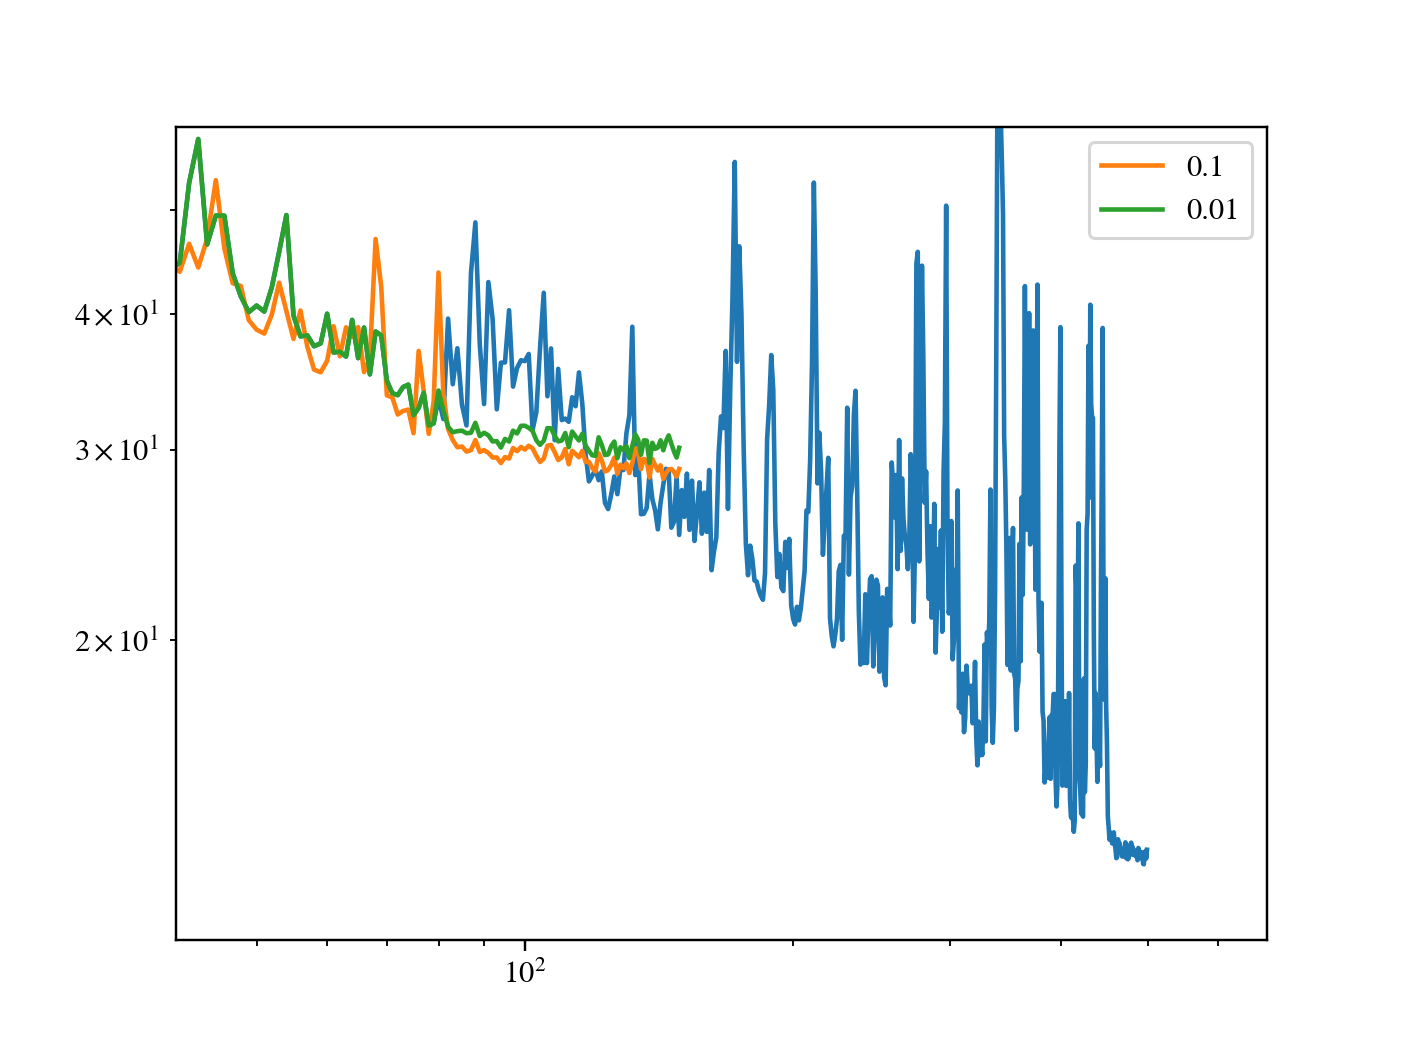

In [56]:
bot = np.min(res_wd)
print(bot)
# for ii in range(len(wd_values)):
plt.plot(res_nh[0])
for ii in range(niter):
    plt.plot(res_wd[ii], label=str(wd_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

### Hidden layers
2

In [13]:
niter = 2
nh_values = np.array([2, 3])
res_nh = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        target_space="p3d",
        nepochs=100,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=owd,
        nhidden=int(nh_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_nh.append(np.mean(arr, axis=1))

1  out of  3
Emualtor trained in 20.894758224487305 seconds
2  out of  3
Emualtor trained in 34.011420488357544 seconds
3  out of  3
Emualtor trained in 26.105144262313843 seconds


1.967402334502249


<IPython.core.display.Javascript object>


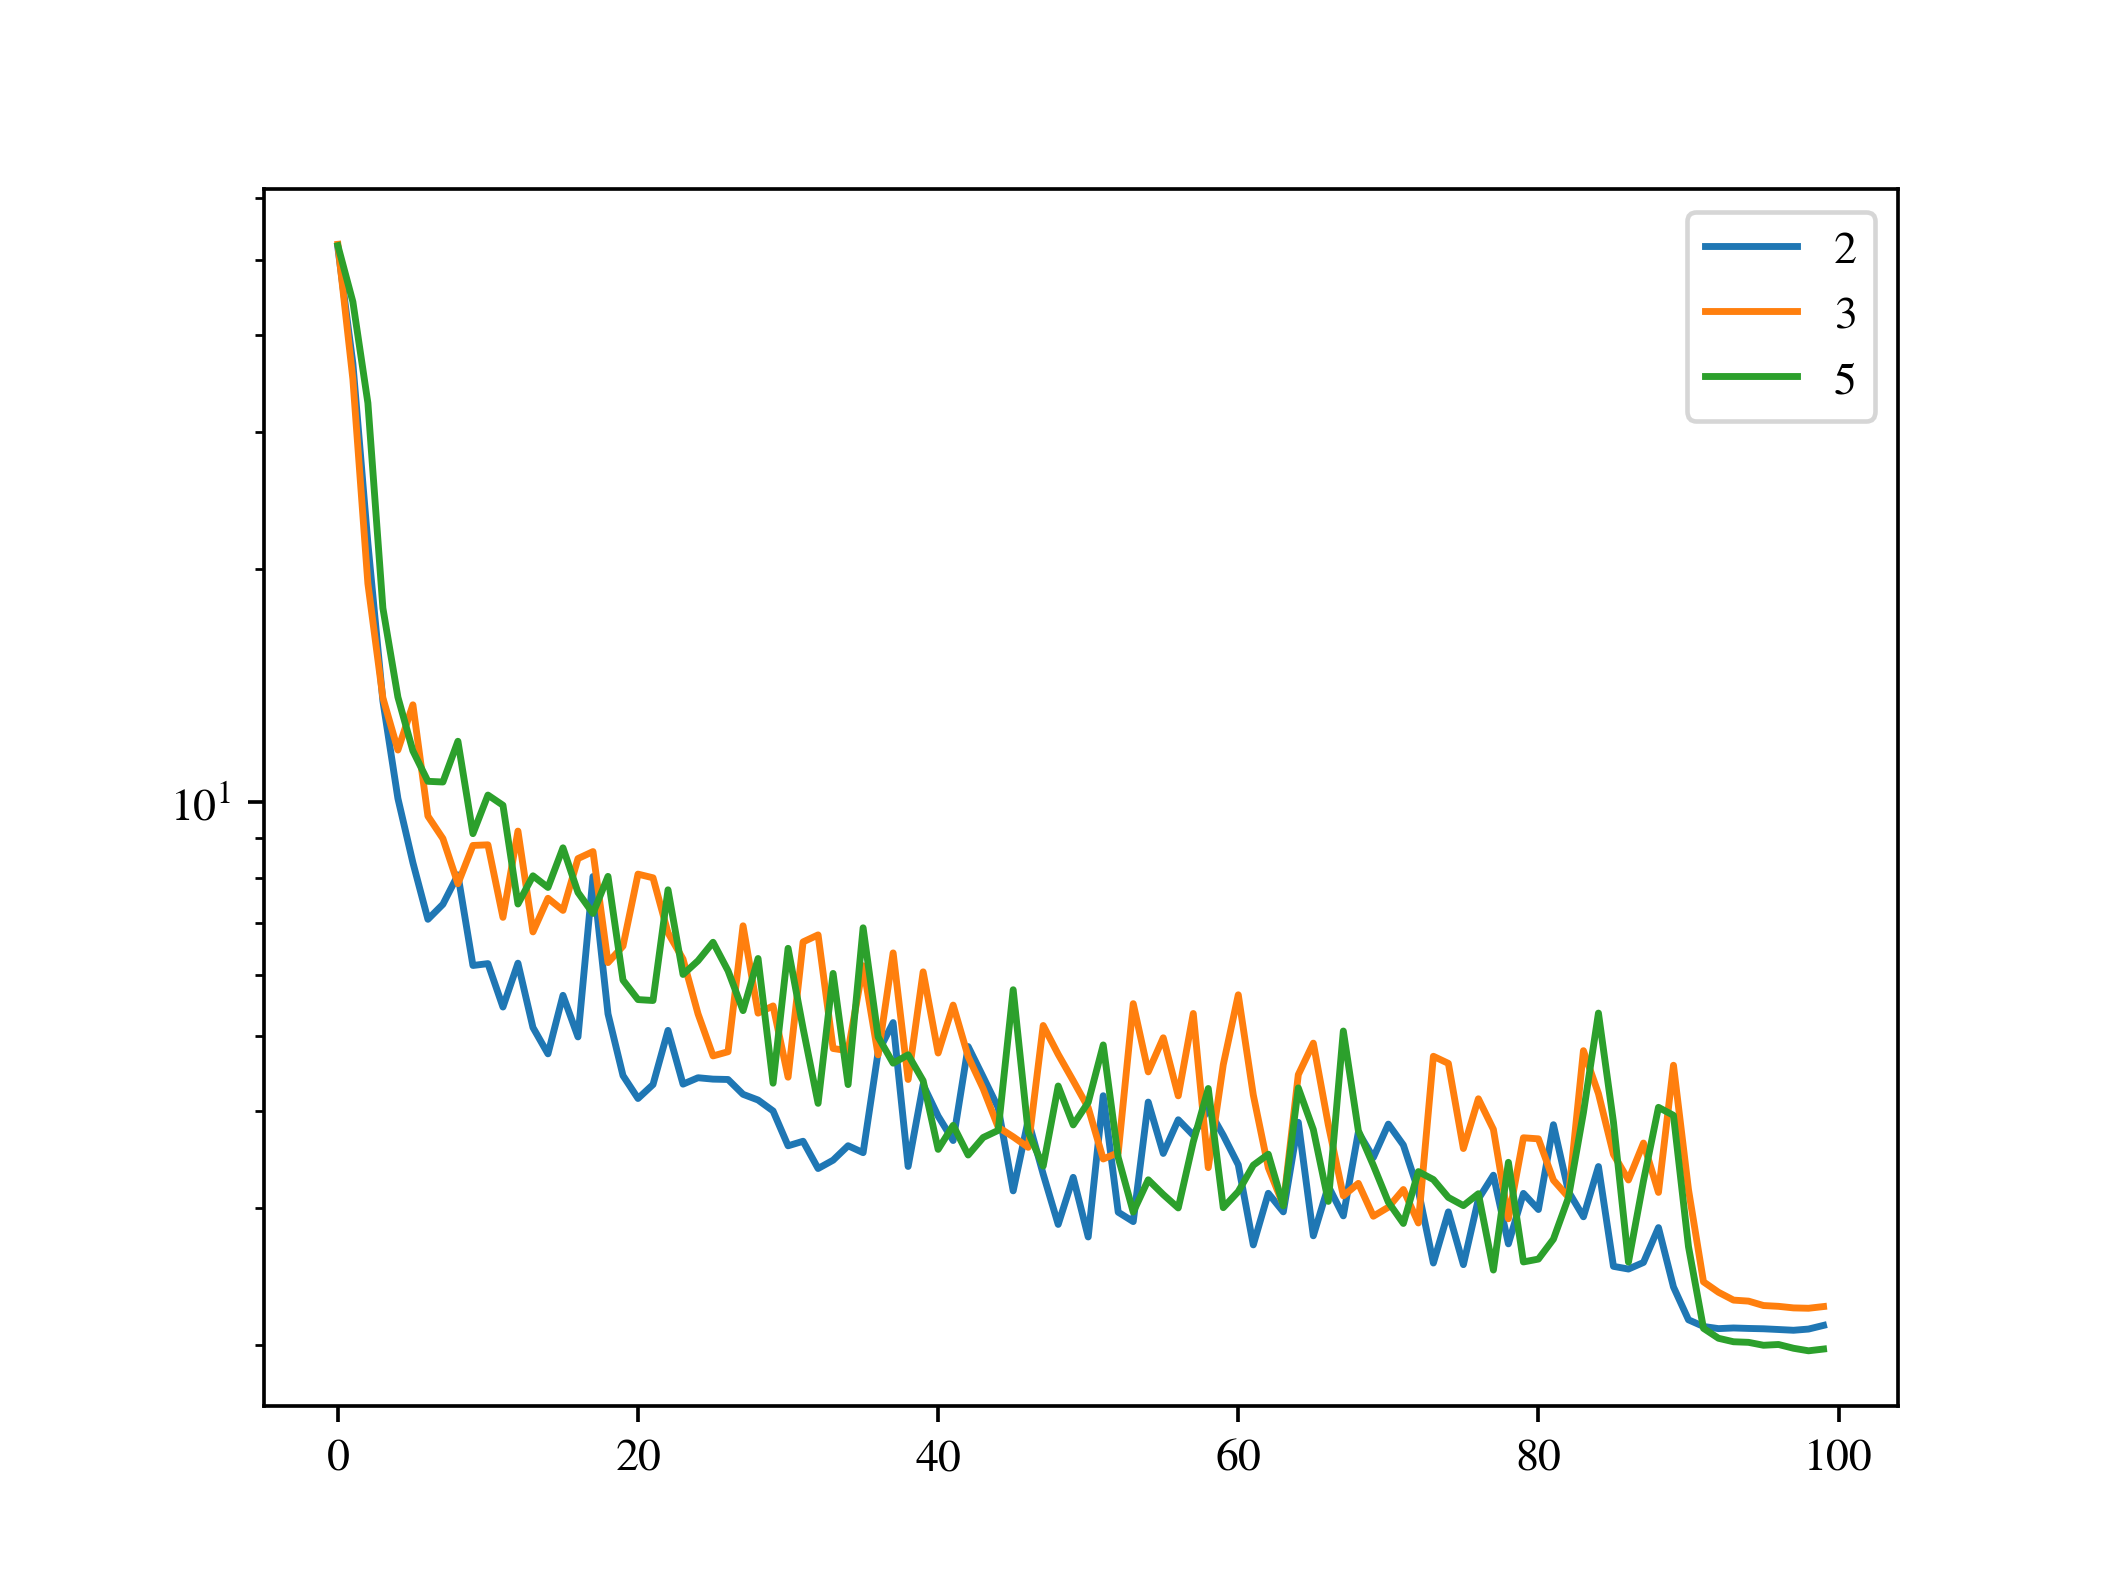

In [14]:
bot = np.min(res_nh)
print(bot)
for ii in range(len(nh_values)):
    plt.plot(res_nh[ii], label=str(nh_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

p1d

In [9]:
nwidth1 = 10
nwidth2 = 100
niter = 2
nh_values = np.array([2, 3])
res_nh = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=Archive3D.rel_err_p3d,
        rerr_p1d=Archive3D.rel_err_p1d,
        target_space="p3dp1d",
        nwidth1=nwidth1,
        nwidth2=nwidth2,
        new_arch=True,
        nepochs=80,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=owd,
        nhidden=int(nh_values[ii]),
    )
    arr = np.array(p3d_emu.loss_arr)
    res_nh.append(np.mean(arr, axis=1))

1  out of  2
Emualtor trained in 66.22246265411377 seconds
2  out of  2
Emualtor trained in 78.23690462112427 seconds


38.99778909394235


<IPython.core.display.Javascript object>


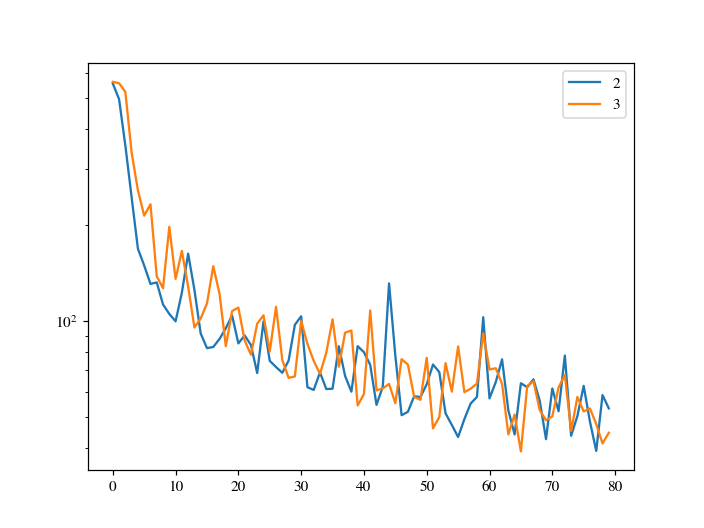

In [10]:
bot = np.min(res_nh)
print(bot)
for ii in range(len(nh_values)):
    plt.plot(res_nh[ii], label=str(nh_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

In [5]:
olr = 5e-3
obs = 200
og = 0.1
owd = 0.01
# ohid = 2
# oss = 450
# nepochs = 500
ohid = 1
# nepochs = 1
oss = 1000
nepochs = 2000
nwidth1 = nwidth2 = 5
# oss = 90
# nepochs = 100

In [6]:
err_p3d_sys = 0.075
err_p1d_sys = 0.0075

rerr_p3d = np.sqrt(Archive3D.rel_err_p3d**2 + err_p3d_sys**2)
rerr_p3d[:, -1] *= 0.5
rerr_p1d = np.sqrt(Archive3D.rel_err_p1d**2 + err_p1d_sys**2)

# rerr_p3d = np.ones_like(Archive3D.rel_err_p3d) + err_p3d_sys
# rerr_p1d = np.ones_like(Archive3D.rel_err_p1d) + err_p1d_sys

In [111]:
res_nh3 = res_nh[0]

In [7]:
niter = 1
nh_values = np.array([1, 2], dtype=int)
res_nh = []

for ii in range(niter):
    print(ii + 1, " out of ", niter)
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)
    p3d_emu = P3DEmulator(
        Archive3D.training_data,
        Archive3D.emu_params,
        rerr_p3d=rerr_p3d,
        rerr_p1d=rerr_p1d,
        k3d_max_Mpc=4.5,
        k1d_max_Mpc=4.5,
        target_space="p3dp1d",
        nwidth1=nwidth1,
        nwidth2=nwidth2,
        new_arch=True,
        nepochs=nepochs,
        lr=olr,
        batch_size=obs,
        step_size=oss,
        gamma=og,
        weight_decay=owd,
        nhidden=nh_values[ii],
    )
    arr = np.array(p3d_emu.loss_arr)
    res_nh.append(np.mean(arr, axis=1))

1  out of  1
Emualtor trained in 439.0252788066864 seconds


440 s

Next steps:

- Launch fits from all data combinations

- L1O tests

- Decide metric for comparison with NFs:
    - Average precision? 
    - Worse? 
    - Reduced chi2 with errors estimated from simulations
    - Previous for all redshifts of one sim? or L1O?

1.7282025946511164


<IPython.core.display.Javascript object>


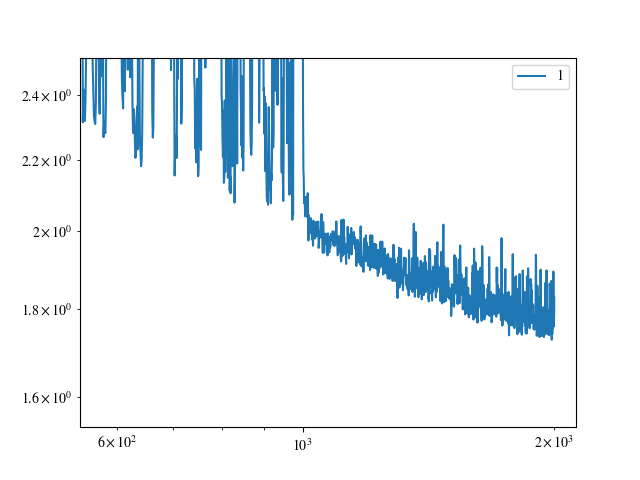

In [10]:
bot = np.min(res_nh)
print(bot)
# plt.plot(res_nh2, "-")
# plt.plot(res_nh3, ":")
for ii in range(niter):
    plt.plot(res_nh[ii], label=str(nh_values[ii]))
# plt.ylim([-0.01, 1])
plt.legend()

- 16 for nw=5, oss 290, nepochs 300
- 12 for nw=5, oss 450, nepochs 500 (300s)

use all training data?

launch fits for all data combinations

In [79]:
# torch.save(p3d_emu.emulator.state_dict(), "p3dpd1emu_v0.pt")

In [115]:
for ii in range(11):
    plt.close()

/tmp/ipykernel_171984/1898272775.py:2: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


fit {'bias': -0.34486724764089416, 'beta': 0.9185428879634573, 'q1': 0.5916161114683118, 'kvav': 0.9115729485132611, 'av': 0.5719766141289313, 'bv': 1.9243983713618498, 'kp': 13.839086476505287, 'q2': 0.2823080933497336}
emu {'bias': 0.32658782601356506, 'beta': 1.0322446823120117, 'q1': 0.9576665759086609, 'kvav': 0.8954710364341736, 'av': 0.5193276405334473, 'bv': 1.9386577606201172, 'kp': 13.955991744995117, 'q2': 0.043107956647872925}


<IPython.core.display.Javascript object>


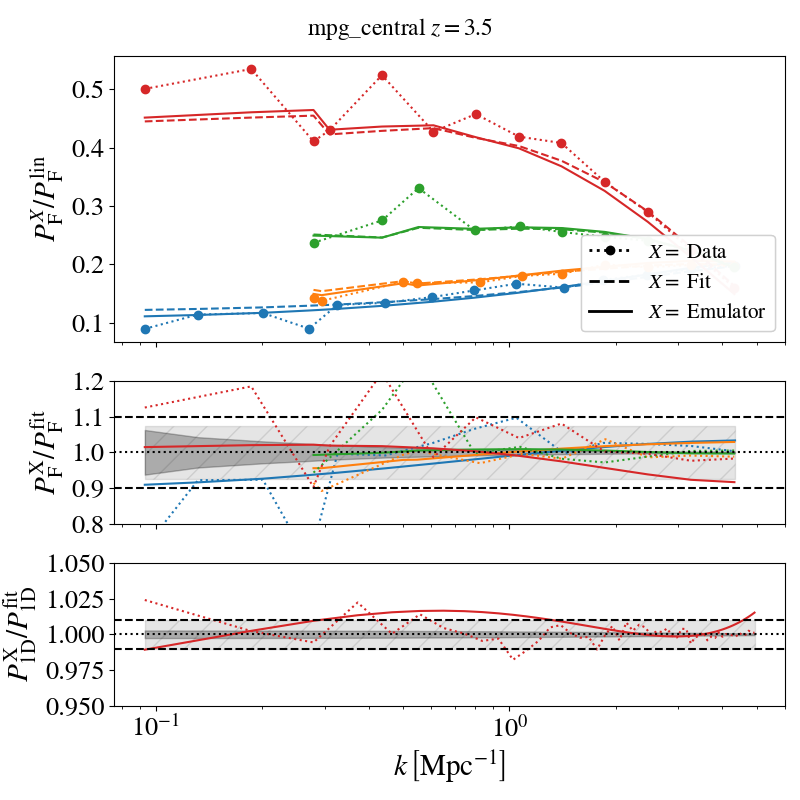

In [11]:
from lya_pk.plots_v0 import plot_test_p3d

sim_label = "mpg_central"
for ind_book in range(4, 5):
    plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

fit {'bias': -0.35860244226557314, 'beta': 0.9443840666750225, 'q1': 0.09263572539239359, 'kvav': 0.5650507049963793, 'av': 0.2865796223042739, 'bv': 1.8621409309544408, 'kp': 11.814270064440315, 'q2': 0.9111149232884375}
emu {'bias': 0.3262682855129242, 'beta': 1.0322026014328003, 'q1': 0.9574501514434814, 'kvav': 0.8963841199874878, 'av': 0.519568145275116, 'bv': 1.9389933347702026, 'kp': 13.960355758666992, 'q2': 0.04278981685638428}


<IPython.core.display.Javascript object>


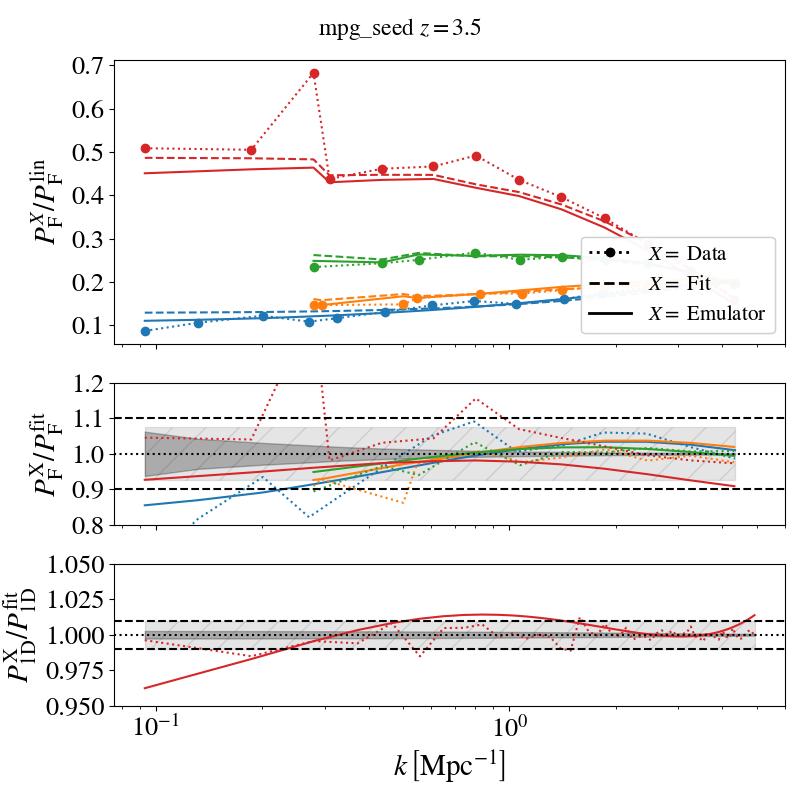

In [12]:
from lya_pk.plots_v0 import plot_test_p3d

sim_label = "mpg_seed"
for ind_book in range(4, 5):
    plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)

In [57]:
testing_data = Archive3D.get_testing_data(
    "mpg_seed", force_recompute_plin=True
)

fit {'bias': -0.300441171115872, 'beta': 1.0394626253329582, 'q1': 0.3552749464536346, 'kvav': 0.7932097878195965, 'av': 0.5451407189422195, 'bv': 1.9168906916324877, 'kp': 14.323321635542495, 'q2': 0.5319767808715724}
emu {'bias': 0.2889126241207123, 'beta': 1.0808964967727661, 'q1': 0.8966134786605835, 'kvav': 0.8928876519203186, 'av': 0.5302266478538513, 'bv': 1.9254541397094727, 'kp': 13.75743293762207, 'q2': 0.021145910024642944}


<IPython.core.display.Javascript object>


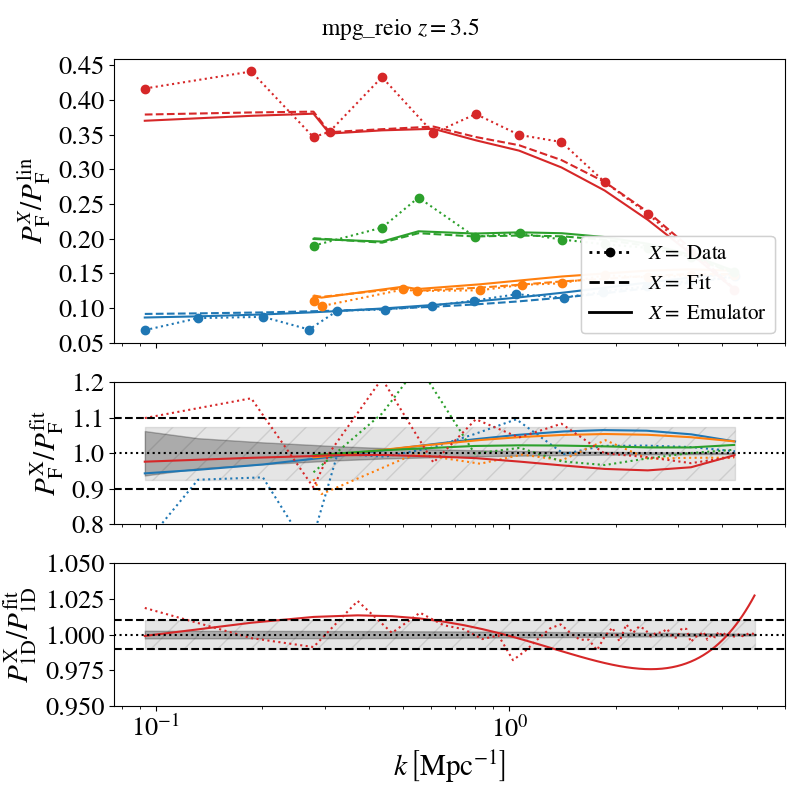

In [13]:
from lya_pk.plots_v0 import plot_test_p3d

sim_label = "mpg_reio"
for ind_book in range(4, 5):
    plot_test_p3d(ind_book, Archive3D, p3d_emu, sim_label)